In [2]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

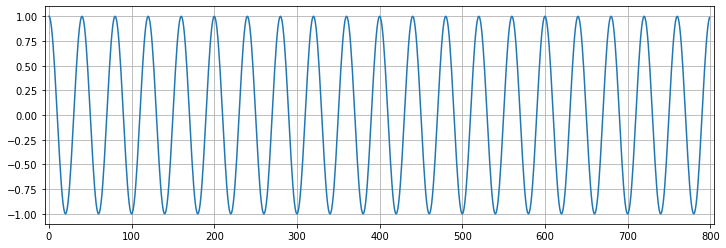

In [6]:
X = torch.linspace(0, 799, 800)
X = torch.cos(X * 3.1416 / 20)

plt.figure(figsize=(12, 4))
plt.grid()
plt.xlim(-5, 805)
plt.plot(X)

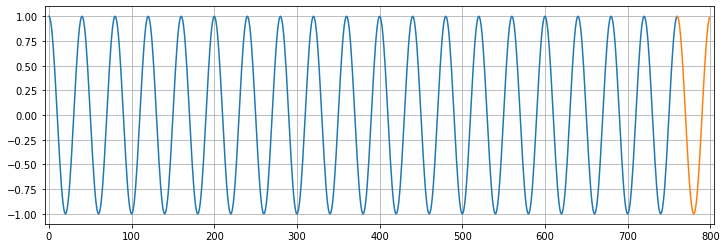

In [9]:
window_size = 40

train_data = X[:-window_size]
test_data = X[-window_size:]

plt.figure(figsize=(12, 4))
plt.grid()
plt.xlim(-5, 805)
plt.plot(train_data)
plt.plot(range(760, 800), test_data)

In [10]:
def split_train(data, ws):

    out = []
    L = len(data)
    for i in range(L - ws):
        t = data[i:i + ws]
        l = data[i + ws:i + ws + 1]
        out.append((t, l))
    return out

In [21]:
Xy_train = split_train(train_data, window_size)
print(Xy_train[:3])
print(len(Xy_train))

[(tensor([ 1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9101e-01,  8.0902e-01,
         7.0711e-01,  5.8778e-01,  4.5399e-01,  3.0901e-01,  1.5643e-01,
        -3.6200e-06, -1.5644e-01, -3.0902e-01, -4.5399e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
        -7.0710e-01, -5.8778e-01, -4.5398e-01, -3.0901e-01, -1.5642e-01,
         1.0502e-05,  1.5645e-01,  3.0903e-01,  4.5400e-01,  5.8780e-01,
         7.0712e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01]), tensor([1.])), (tensor([ 9.8769e-01,  9.5106e-01,  8.9101e-01,  8.0902e-01,  7.0711e-01,
         5.8778e-01,  4.5399e-01,  3.0901e-01,  1.5643e-01, -3.6200e-06,
        -1.5644e-01, -3.0902e-01, -4.5399e-01, -5.8779e-01, -7.0711e-01,
        -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01, -1.0000e+00,
        -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01, -7.0710e-01,
        -5.8778e-01, -4.5398e-0

In [97]:
# Network class to be trained and tested.
class LSTMNetwork(nn.Module):

    def __init__(self, in_features=1, hidden_size=60, out_features=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(in_features, hidden_size, num_layers=3)
        self.linear = nn.Linear(hidden_size, out_features)
        self.hidden = (torch.zeros(3, 1, hidden_size), torch.zeros(3, 1, hidden_size))

    def forward(self, X):
        lstm, _ = self.lstm(X.view(len(X), 1, -1), self.hidden)
        X = self.linear(lstm.view(len(lstm), -1))
        return X[-1]

model = LSTMNetwork()
model

LSTMNetwork(
  (lstm): LSTM(1, 60, num_layers=3)
  (linear): Linear(in_features=60, out_features=1, bias=True)
)

In [98]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

count = 0
for param in model.parameters():
    count += param.numel()
print(count)

73741


epoch: 1, loss: 0.9769380688667297
epoch: 2, loss: 0.8988397717475891
epoch: 3, loss: 0.42120400071144104
epoch: 4, loss: 0.13038504123687744
epoch: 5, loss: 0.001716103870421648
epoch: 6, loss: 0.0016533441375941038
epoch: 7, loss: 0.0014986346941441298
epoch: 8, loss: 0.0013091058935970068
epoch: 9, loss: 0.0011308735702186823
epoch: 10, loss: 0.000978101626969874


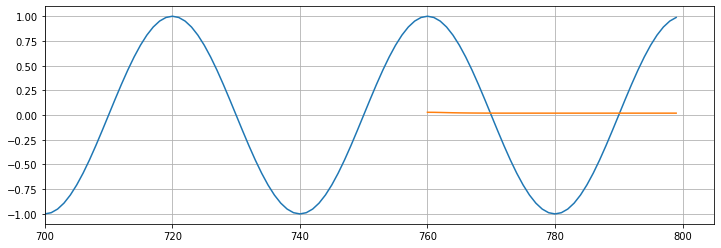

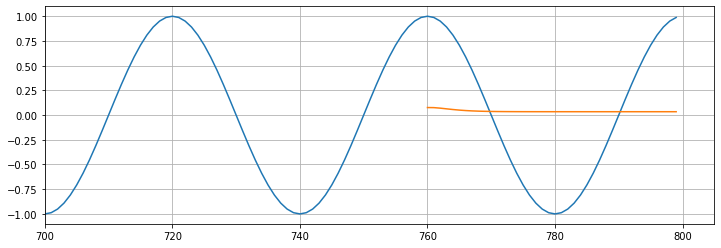

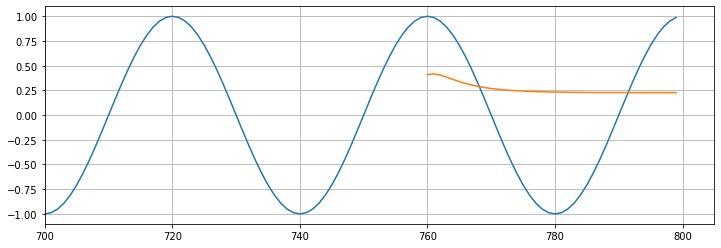

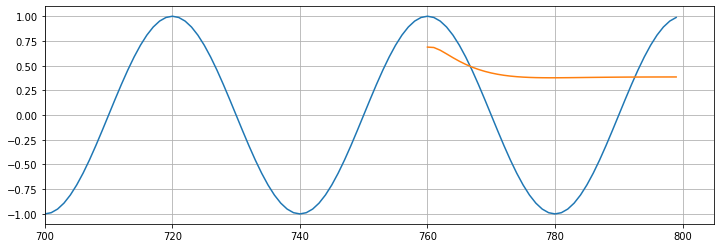

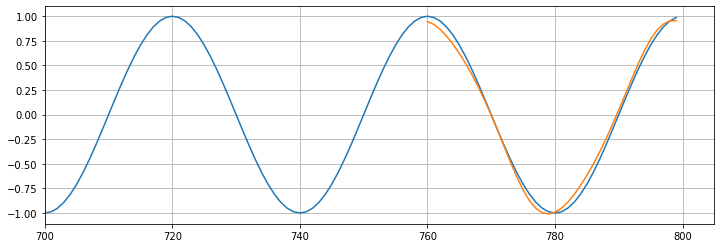

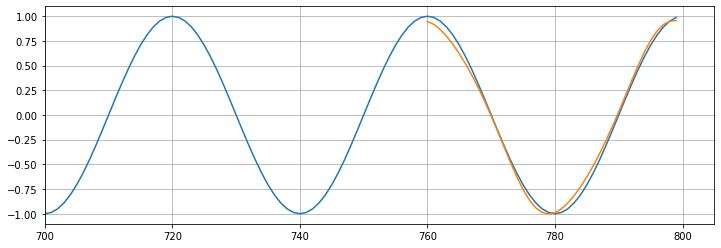

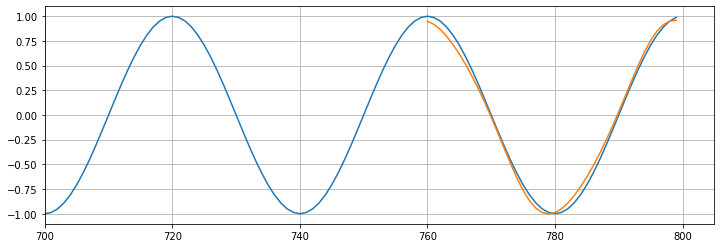

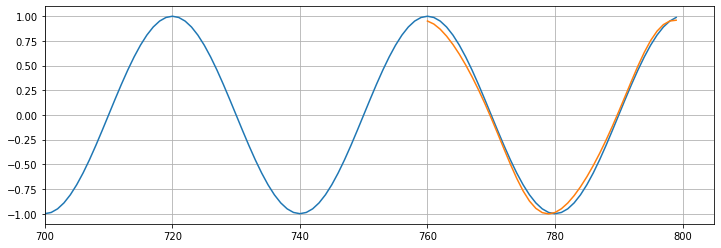

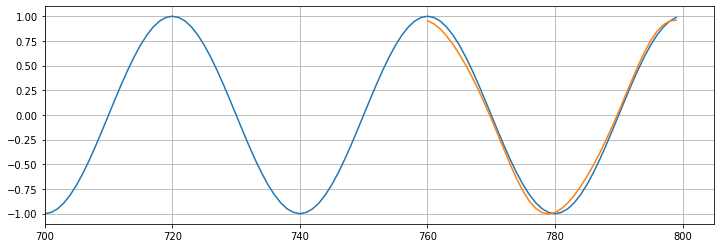

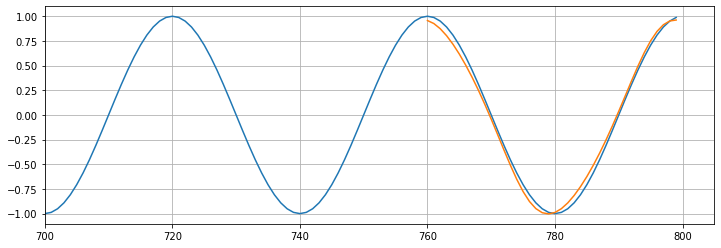

In [99]:
# Training the model.
epochs = 10
future = 40

for i in range(epochs):
    i += 1
    loss = 0
    # Train the model with train data.
    for X_train, y_train in Xy_train:

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        model.hidden = (torch.zeros(3, 1, model.hidden_size), torch.zeros(3, 1, model.hidden_size))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'epoch: {i}, loss: {loss}')

    # Test the model with test data.
    preds = train_data[-window_size:].tolist()
    for f in range(future):
        f += 1
        with torch.no_grad():

            seq = torch.tensor(preds[-window_size:])

            model.hidden = (torch.zeros(3, 1, model.hidden_size), torch.zeros(3, 1, model.hidden_size))
            y_pred = model(seq)

            preds.append(y_pred)

        loss = criterion(torch.tensor(preds[-window_size:]), test_data)

    plt.figure(figsize=(12, 4))
    plt.grid()
    plt.xlim(700, 805)
    plt.plot(X)
    plt.plot(range(760, 800), preds[-window_size:])
    plt.show()

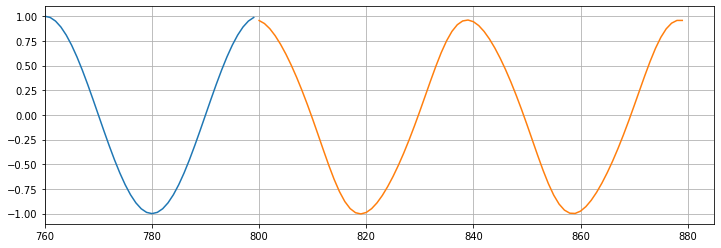

In [102]:
# Predict two-windows from trained model.
future = window_size * 2

preds = X[-window_size:].tolist()
for f in range(future):

    with torch.no_grad():

        seq = torch.tensor(preds[-window_size:])
        y_pred = model(seq)

        preds.append(y_pred)

plt.figure(figsize=(12, 4))
plt.xlim(760, 885)
plt.grid()
plt.plot(X)
plt.plot(range(800, 880), preds[-window_size * 2:])
plt.show()